In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import polars as pl
import numpy as np

from adex.models import Condition, ConditionDataLoader, ConditionSequencingTissueDataLoader, \
    ConditionSequencingDataLoader, SequencingTechnique, TissueEnum, METADATA_COLUMNS, FileDataLoader, DataLoader
from adex.helpers import get_pre_processed_dataset, run_ml_model
from adex.models import DATASET_INFO_COLUMNS
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from adex.pca import PcaHelper

data_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.csv"
datasets_info_path = "../data/adex-database/datasets_info.csv"
results_path = "../results"

# Prepare Data

In [17]:
pca = PcaHelper(
    FileDataLoader(
        condition=Condition.RA,
        file_name="GSE89408.tsv.parquet",
        genes=None
    ),
    data_path,
    metadata_path,
    datasets_info_path, 
    n_components=10
)
x_df = pca.pca_as_pandas_dataframe()
x_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-80.131868,34.493940,-33.219750,-41.757135,-4.093533,29.436991,22.395374,-20.049588,-17.310673,0.969714
1,33.923073,-5.388018,-42.709265,-12.761341,-19.555802,-27.750280,-26.865622,20.921074,-0.832624,-1.067989
2,-19.970015,-14.105792,0.598999,2.303008,-13.620063,-16.673194,0.730344,-11.344536,-6.682035,-6.072063
3,-47.297956,-31.706893,24.680044,57.575226,5.694822,-0.395966,13.069301,2.928389,8.173000,11.580742
4,-39.590461,4.591218,-47.167794,-9.829566,-10.112884,-15.611538,-3.943881,-4.010429,-17.789053,-5.233316
...,...,...,...,...,...,...,...,...,...,...
175,-103.737399,61.739987,23.632720,-12.494208,19.458652,2.564135,11.459156,-16.906637,3.512367,-0.745058
176,-36.678829,19.441643,24.024881,-28.945445,-13.429439,-1.247321,0.698874,-7.049016,11.706593,-2.432167
177,-35.633061,-10.800840,-31.022957,-2.925827,0.868302,27.185374,26.762191,-18.407555,-9.131130,-7.236949
178,-39.334204,5.764995,15.161815,-22.668509,-15.503817,-18.325651,-6.060744,6.786504,-9.510695,19.787247


In [14]:
explained_variance = pca.explained_variance_ratio()
explained_variance

array([0.28168329, 0.12952031, 0.08942914, 0.04614029, 0.03573383,
       0.03380668, 0.02576112, 0.02373083, 0.01952546, 0.01675544])

In [15]:
total_explained_variance = sum(explained_variance)
total_explained_variance

0.7020863918162167

In [23]:
y_df = (
    get_pre_processed_dataset(
        data_loader=FileDataLoader(
            condition=Condition.RA,
            file_name="GSE89408.tsv.parquet",
            genes=None
        ),
        data_path=data_path,
        metadata_path=metadata_path,
        datasets_info_path=datasets_info_path,
        return_metadata=True
    ).fill_null(value=0)
    .with_columns(
        pl.col("Condition")
        .map_elements(lambda x: 0 if x == "Healthy" else 1, return_dtype=pl.Int8)
        .alias("class_label")
    )
    .select("class_label")
).select(pl.col("class_label").alias("y")).to_pandas()
y_df

,y
0,1
1,1
2,1
3,1
4,1
...,...
175,0
176,1
177,1
178,1


In [24]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_df, y_df, 
    train_size=0.7, 
    random_state=42,  # Ensure a reproducible split 
    shuffle=True, 
    stratify=y_df  # solve the class imbalance issue 
)

In [25]:
x_train

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
98,-40.431730,-12.838468,0.288239,26.999777,7.344974,-8.241977,10.684090,-14.883704,-5.480965,-11.042435
51,91.831331,-7.194348,88.001840,-45.699352,-25.088276,1.940491,-40.744221,43.563921,8.901480,-15.737956
41,-7.551361,-0.673604,84.611107,13.065395,-18.557884,13.496663,6.130980,23.613054,33.157266,42.918003
44,-20.194455,-0.603050,10.328940,-3.602219,-5.778943,-20.304009,-11.701214,-2.667776,7.025893,-18.277543
32,-47.838121,-3.763053,80.287999,12.198203,11.831786,14.187268,1.512925,4.086828,-0.795403,-10.631193
...,...,...,...,...,...,...,...,...,...,...
28,3.468766,-28.655673,-22.021753,13.278060,-12.714623,-14.269670,-3.658246,-0.896306,2.871494,1.490066
40,-40.858543,7.430115,-6.701495,6.550733,-17.166282,-22.251007,-0.793156,-1.361049,27.772549,22.192537
174,-37.931176,21.184889,83.014531,5.431828,24.939893,1.742674,-19.402764,11.634857,7.919671,-23.309240
70,-28.243712,5.207128,-17.791853,-18.124275,-7.859760,3.538716,6.796104,-5.080511,-61.730623,93.146519


In [26]:
y_train

,y
98,0
51,1
41,0
44,0
32,1
...,...
28,1
40,1
174,1
70,1


In [27]:
y_train.value_counts()

y
1    106
0     19
Name: count, dtype: int64

In [28]:
x_test

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
114,-30.527728,-35.307591,45.512263,57.525430,45.268305,7.561046,6.059752,-9.347646,-13.613729,-29.307033
81,31.932951,-35.594546,10.595400,17.817587,-17.119552,-2.387584,-0.028247,4.198518,14.905281,1.662027
161,-11.714884,-17.744180,23.617687,7.324295,-15.820247,-15.742662,1.828982,-0.687310,2.820049,-0.345168
134,-48.865956,-1.106569,71.909428,21.853914,24.402915,4.527571,-0.793336,3.284473,-9.269481,-8.429871
1,33.923073,-5.388018,-42.709265,-12.761341,-19.555802,-27.750280,-26.865622,20.921074,-0.832624,-1.067989
71,55.642409,-61.834036,-8.593643,15.362789,-5.773843,34.284776,19.909237,4.001687,16.263364,-10.800709
157,-70.914556,-13.627926,43.714808,26.712491,-2.514826,9.530965,15.152334,-2.779961,-7.687028,10.943619
89,52.886710,-43.701431,6.538025,27.768493,-19.722146,-14.186676,-2.810862,12.995712,19.785371,17.580593
52,-42.167086,56.141660,-24.741954,-64.565723,2.228644,36.186046,9.300477,3.756944,21.966390,-5.713286
19,-26.035941,-2.173859,-26.844849,-33.459166,6.303462,33.700141,8.010046,-3.424210,-21.727015,9.009630


In [29]:
y_test

,y
114,0
81,1
161,1
134,1
1,1
71,1
157,1
89,1
52,1
19,1


In [31]:
y_test.value_counts()

y
1    46
0     9
Name: count, dtype: int64

# Logistic Regression 

Default Parameters of Base Model: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Scores (cv=4): 0.8125,0.8387096774193549,0.7741935483870968,0.7419354838709677
Cross Validation gives 0.79 accuracy with a standard deviation of 0.04

Metrics on the Test Set:

        Accur

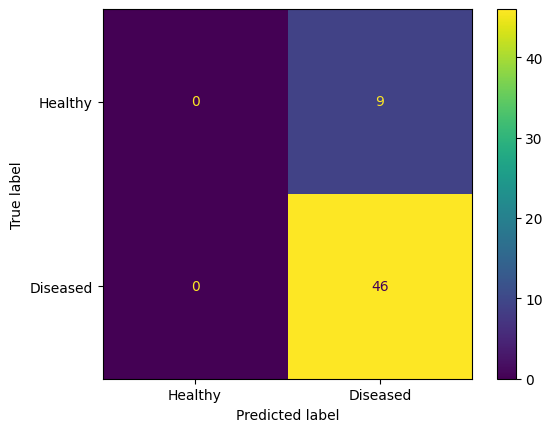

In [32]:
logistic_model, _ = run_ml_model(
    classifier=LogisticRegression(solver='liblinear', random_state=0),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
)

In [33]:
logistic_model.intercept_

array([2.02735313])

In [34]:
logistic_model.coef_

array([[ 1.92195799e-02, -3.07909397e-03,  1.39401712e-03,
         9.40404996e-05,  9.34102022e-03,  1.23097699e-04,
        -1.45004160e-02,  1.82549832e-03, -1.68777006e-02,
        -4.49857531e-03]])

In [35]:
logistic_model.predict_proba(x_test)

array([[9.12347300e-02, 9.08765270e-01],
       [8.65933546e-02, 9.13406645e-01],
       [1.58836295e-01, 8.41163705e-01],
       [1.63248954e-01, 8.36751046e-01],
       [5.23656851e-02, 9.47634315e-01],
       [6.18246941e-02, 9.38175306e-01],
       [3.53607594e-01, 6.46392406e-01],
       [6.56452104e-02, 9.34354790e-01],
       [3.64538177e-01, 6.35461823e-01],
       [1.46805501e-01, 8.53194499e-01],
       [1.32530036e-01, 8.67469964e-01],
       [7.07728612e-05, 9.99929227e-01],
       [1.72788992e-01, 8.27211008e-01],
       [1.61274051e-01, 8.38725949e-01],
       [2.88254989e-01, 7.11745011e-01],
       [2.02623567e-01, 7.97376433e-01],
       [3.24998893e-01, 6.75001107e-01],
       [3.27588335e-01, 6.72411665e-01],
       [1.57064874e-01, 8.42935126e-01],
       [1.96280158e-01, 8.03719842e-01],
       [5.06214388e-02, 9.49378561e-01],
       [1.16024569e-01, 8.83975431e-01],
       [2.62646146e-01, 7.37353854e-01],
       [3.11984303e-04, 9.99688016e-01],
       [2.819726

# Decision Tree 

Default Parameters of Base Model: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
Parameters for tuning provided: {'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
Cross Validation Scores (cv=4): 0.71875,0.8387096774193549,0.7419354838709677,0.7096774193548387
Cross 

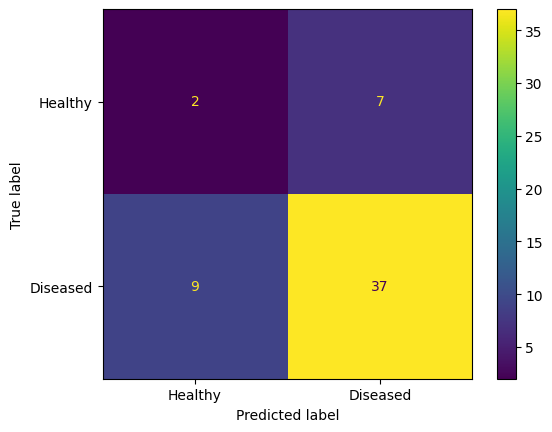

In [36]:
from sklearn import tree

tree_model, _ = run_ml_model(
    classifier=tree.DecisionTreeClassifier(),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
)

[Text(0.49166666666666664, 0.9285714285714286, 'x[0] <= -54.866\ngini = 0.258\nsamples = 125\nvalue = [19, 106]'),
 Text(0.3, 0.7857142857142857, 'x[8] <= -15.301\ngini = 0.496\nsamples = 11\nvalue = [6, 5]'),
 Text(0.23333333333333334, 0.6428571428571429, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.36666666666666664, 0.6428571428571429, 'gini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.6833333333333333, 0.7857142857142857, 'x[7] <= 6.443\ngini = 0.202\nsamples = 114\nvalue = [13, 101]'),
 Text(0.5, 0.6428571428571429, 'x[7] <= 0.853\ngini = 0.275\nsamples = 73\nvalue = [12, 61]'),
 Text(0.3333333333333333, 0.5, 'x[9] <= -7.308\ngini = 0.203\nsamples = 61\nvalue = [7, 54]'),
 Text(0.2, 0.35714285714285715, 'x[6] <= 9.805\ngini = 0.391\nsamples = 15\nvalue = [4, 11]'),
 Text(0.13333333333333333, 0.21428571428571427, 'x[5] <= -14.559\ngini = 0.18\nsamples = 10\nvalue = [1, 9]'),
 Text(0.06666666666666667, 0.07142857142857142, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Tex

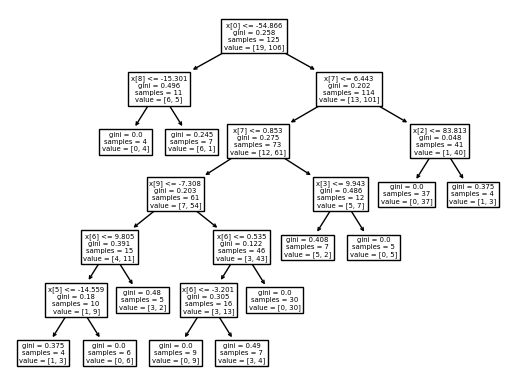

In [37]:
tree.plot_tree(tree_model)

# Gradient boosted Tree

Default Parameters of Base Model: {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'max_iter': [100, 1000, 1500], 'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [25, 50, 75], 'l2_regularization': [0.0, 1.5]}
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 25, 'max_featu

(HistGradientBoostingClassifier(max_depth=25, max_iter=1000),
 array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8))

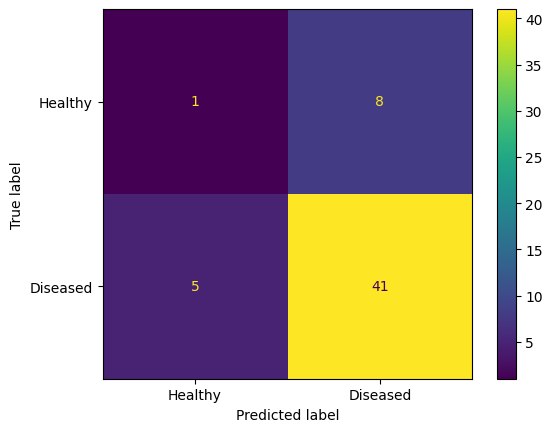

In [38]:
from sklearn.ensemble import HistGradientBoostingClassifier

run_ml_model(
    classifier=HistGradientBoostingClassifier(max_iter=100),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={
        "max_iter": [100, 1000, 1500],
        "learning_rate": [0.1, 0.2, 0.3],
        "max_depth": [25, 50, 75],
        "l2_regularization": [0.0, 1.5]
    }
)

# Random Forest 

Default Parameters of Base Model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'bootstrap': [True, False], 'max_depth': [10, 50, 100, None], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [10, 100, 1000]}
Fitting 4 folds for each of 216 candidates, totalling 864 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_sa

(RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=10),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8))

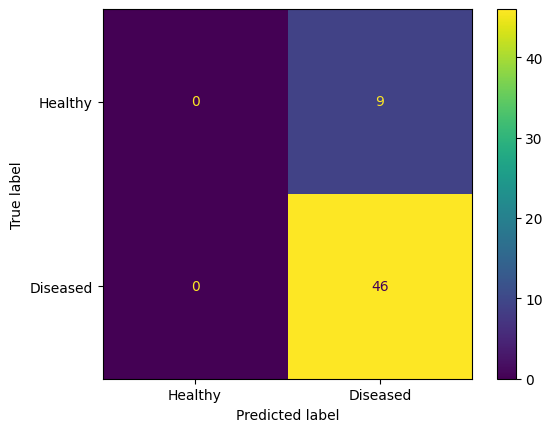

In [39]:
from sklearn.ensemble import RandomForestClassifier

# worst than using the defaults 
run_ml_model(
    classifier=RandomForestClassifier(n_estimators=10),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={
        'bootstrap': [True, False],
        'max_depth': [10, 50, 100, None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [10, 100, 1000]
    }
)

Default Parameters of Base Model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Running with base model
Cross Validation Scores (cv=4): 0.78125,0.7741935483870968,0.7419354838709677,0.8387096774193549
Cross Validation gives 0.78 accuracy with a standard deviation of 0.03

Metrics on the Test Set:

        Accuracy: 0.8181818181818182
        Precision: 0.8333333333333334
        Recall: 0.9782608695652174
        f1: 0.9
    


(RandomForestClassifier(n_estimators=10),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8))

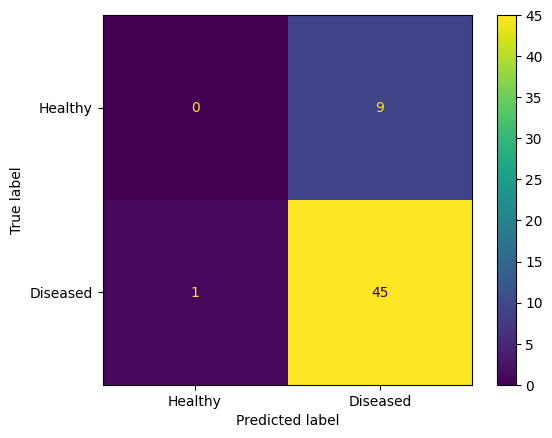

In [40]:
run_ml_model(
    classifier=RandomForestClassifier(n_estimators=10),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

# SVMs

Default Parameters of Base Model: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Parameters for tuning provided: {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Scores (cv=4): 0.84375,0.8387096774193549,0.8387096774193549,0.8709677419354839
Cross Validation gives 0.85 accuracy with a standard deviation of 0.01

Metrics o

(SVC(C=0.1, gamma=1),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8))

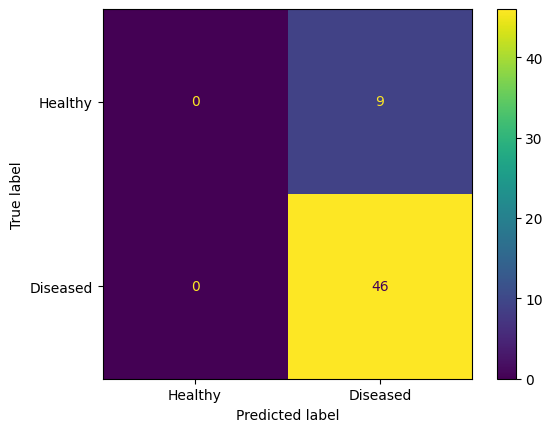

In [41]:
from sklearn import svm

run_ml_model(
    classifier=svm.SVC(),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
    }
)